# Node Classification using Simple Graph Convolution Network

**Objective:**
Design and implement a Graph Convolution Network (GCN) to predict community memberships in the Karate Club social network graph.

**Dataset:**
Utilize the Karate Club graph dataset, where nodes represent individuals in a university karate club, and edges represent friendships between them. Each node is associated with a ground truth community label, either 'Mr. Hi' or 'Officer'.

**Task Steps:**

1. **Data Preparation:**
   - Load the Karate Club graph using the provided networkx library.
   - Convert the graph into PyTorch tensors, including the adjacency matrix and ground truth community labels.

2. **Model Architecture:**
   - Implement a simple Graph Convolutional Network (GCN) to learn node representations.
   - $H_{\ell} = AH_{\ell-1}\theta_{\ell}$
   - The GCN should consist of at least two layers with a ReLU activation function.

3. **Loss Function and Optimization:**
   - Utilize the CrossEntropyLoss as the objective function, as the task involves multi-class classification.
   - Use the Adam optimizer for model parameter updates.

4. **Training Procedure:**
   - Train the GCN for a specified number of epochs.
   - Monitor the training progress by observing the reduction in the CrossEntropyLoss.

5. **Evaluation:**
   - After training, visualize the graph with node colors based on the predicted community memberships.
   - Assess the model's performance by comparing predicted labels with ground truth labels.

**Note:**
Feel free to experiment with different model architectures, hyperparameters, and training strategies to optimize the GNN's performance in predicting community memberships in the Karate Club graph. The task aims to provide hands-on experience in implementing GNNs for community detection in real-world social network data.

In [1]:
# Import packages as required
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
torch.manual_seed(0)
import random 
random.seed(42)
import numpy as np
np.random.seed(42)

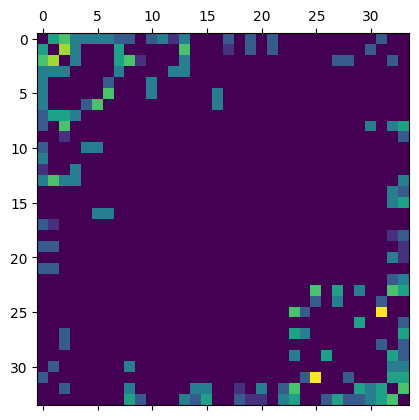

In [9]:
# Load the Karate Club dataset
G = nx.karate_club_graph()

# Convert the networkx graph to PyTorch tensors
# adjacency_matrix = nx.to_numpy_matrix(G)
adjacency_matrix = nx.to_numpy_array(G)
plt.matshow(adjacency_matrix)

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Create the adjacency matrix and normalize along each column
adjacency_matrix = torch.tensor(adjacency_matrix / adjacency_matrix.sum(axis=0), dtype=torch.float32, requires_grad=True)
labels = torch.tensor([0 if G.nodes[i]['club'] == 'Mr. Hi' else 1 for i in range(num_nodes)])


Text(0.5, 1.0, 'Karate Club GNN ground truth')

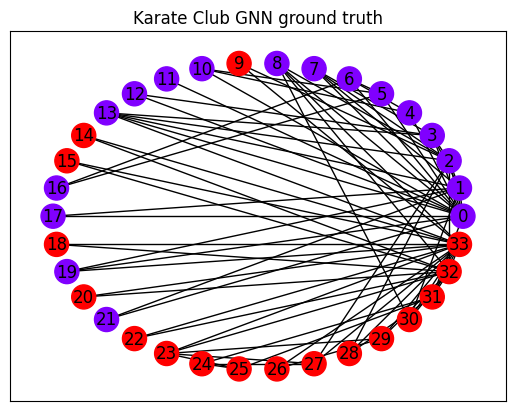

In [3]:
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color=labels, cmap=plt.cm.rainbow)
plt.title("Karate Club GNN ground truth")


In [4]:
idx = torch.randperm(num_nodes)

train_idx = idx[:20]
valid_idx = idx[20:26]
test_idx = idx[26:]
nTrain = len(train_idx)
nValid = len(valid_idx)
nTest = len(test_idx)
print("Using nTrain:%d, nValid %d, nTest: %d"%(nTrain,nValid,nTest))

Using nTrain:20, nValid 6, nTest: 8


In [5]:
# Define the Graph Convolutional Layer
class GraphConvolutionLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolutionLayer, self).__init__()
        self.theta = nn.Parameter(torch.rand(in_features, out_features))  # Initialize weights between [0, 1]

        self.sigma = nn.ReLU()
        
    def forward(self, x, adjacency_matrix):
        D = torch.diag(torch.sum(adjacency_matrix, 1))
        A_tilde = adjacency_matrix + torch.eye(adjacency_matrix.shape[0])
        A_hat = torch.linalg.inv(D) @ A_tilde
        
        # H = Sigma(Â X Theta)
        output = self.sigma(A_hat @ x @ self.theta)
        
        return output

# Define the Graph Neural Network model
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCN, self).__init__()
        self.layer1 = GraphConvolutionLayer(input_size, hidden_size)
        self.layer2 = GraphConvolutionLayer(hidden_size, output_size)

    def forward(self, x0, adjacency_matrix):
        x1 = self.layer1(x0, adjacency_matrix)
        x2 = self.layer2(x1, adjacency_matrix)
        
        return x2

In [6]:
# Initialize the model, loss function, and optimizer
input_size = num_nodes
hidden_size = 16
output_size = 2  # Number of classes in the Karate Club dataset (split into two groups)
model = GCN(input_size, hidden_size, output_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
num_epochs = 200
for epoch in range(num_epochs):
    # Forward pass
    output = model(torch.eye(num_nodes), adjacency_matrix)  # Identity matrix as input features

    # Ground truth labels (Karate Club has two groups)
    labels = torch.tensor([0 if G.nodes[i]['club'] == 'Mr. Hi' else 1 for i in range(num_nodes)])

    # Compute the loss
    loss = criterion(output[train_idx], labels[train_idx])

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    valid_acc = sum(output[valid_idx].max(1)[1] == labels[valid_idx])/nValid

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Tr Loss: {loss.item():.4f}, Vl Acc: {valid_acc.item():.4f}')

test_acc = sum(output[test_idx].max(1)[1] == labels[test_idx])/nTest
print('Test acc: %.2f'%(test_acc))

Epoch [10/200], Tr Loss: 2.1501, Vl Acc: 0.6667
Epoch [20/200], Tr Loss: 0.1086, Vl Acc: 0.8333
Epoch [30/200], Tr Loss: 0.0514, Vl Acc: 0.8333
Epoch [40/200], Tr Loss: 0.0252, Vl Acc: 0.8333
Epoch [50/200], Tr Loss: 0.0167, Vl Acc: 0.8333
Epoch [60/200], Tr Loss: 0.0137, Vl Acc: 0.8333
Epoch [70/200], Tr Loss: 0.0108, Vl Acc: 0.8333
Epoch [80/200], Tr Loss: 0.0089, Vl Acc: 0.8333
Epoch [90/200], Tr Loss: 0.0077, Vl Acc: 0.8333
Epoch [100/200], Tr Loss: 0.0068, Vl Acc: 0.8333
Epoch [110/200], Tr Loss: 0.0060, Vl Acc: 0.8333
Epoch [120/200], Tr Loss: 0.0054, Vl Acc: 0.8333
Epoch [130/200], Tr Loss: 0.0049, Vl Acc: 0.8333
Epoch [140/200], Tr Loss: 0.0045, Vl Acc: 0.8333
Epoch [150/200], Tr Loss: 0.0041, Vl Acc: 0.8333
Epoch [160/200], Tr Loss: 0.0038, Vl Acc: 0.8333
Epoch [170/200], Tr Loss: 0.0035, Vl Acc: 0.8333
Epoch [180/200], Tr Loss: 0.0032, Vl Acc: 0.8333
Epoch [190/200], Tr Loss: 0.0030, Vl Acc: 0.8333
Epoch [200/200], Tr Loss: 0.0028, Vl Acc: 0.8333
Test acc: 1.00


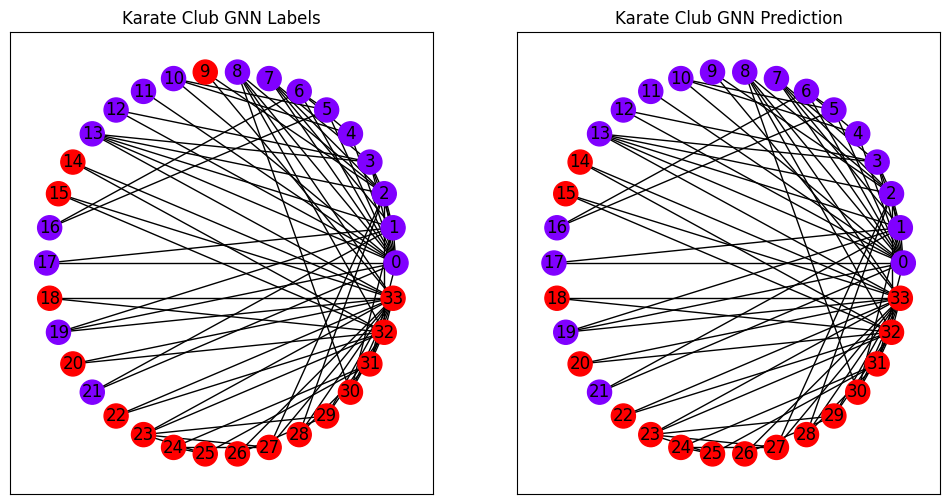

In [7]:
# Plot the final graph with node colors based on the predicted labels
final_output = model(torch.eye(num_nodes), adjacency_matrix)
predicted_labels = torch.argmax(final_output, dim=1).detach().numpy()

plt.figure(figsize=(12,6))
plt.subplot(121)
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color=labels, cmap=plt.cm.rainbow)
plt.title("Karate Club GNN Labels")
plt.subplot(122)

nx.draw_networkx(G, pos, with_labels=True, node_color=predicted_labels, cmap=plt.cm.rainbow)
plt.title("Karate Club GNN Prediction")


plt.show()
